In [9]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import sys
sys.path.insert(0,'..')
from functions import getRad, lowPass, mean_mask
import warnings
warnings.filterwarnings("ignore")

In [10]:
lp = '/scratch-shared/janssens/eurec4a_mean_200km'
sp = lp+'/figs'

klp = 4
qlc = 1e-7

ds = nc.Dataset(lp+'/cape2d.001.nc')
ds1 = nc.Dataset(lp+'/profiles.001.nc')
ds3 = nc.Dataset(lp+'/fielddump.001.nc')

time  = np.ma.getdata(ds.variables['time'][:]) / 3600
xf    = np.ma.getdata(ds.variables['xt'][:]) # Cell centres (f in mhh)
xh    = np.ma.getdata(ds.variables['xm'][:]) # Cell edges (h in mhh)
yf    = np.ma.getdata(ds.variables['yt'][:]) # Cell centres (f in mhh)
yh    = np.ma.getdata(ds.variables['ym'][:]) # Cell edges (h in mhh)

time3 = np.ma.getdata(ds3.variables['time'][:]) / 3600

extent = np.array([xf.min(), xf.max(), xf.min(), xf.max()])/1000

circ_mask = np.zeros((xf.size,xf.size))
rad = getRad(circ_mask)
circ_mask[rad<=klp] = 1

# Calculate column-averaged density
zf = ds1['zt'][:].data
rhob = ds1['rhobf'][0,:].data
rho0 = np.trapz(rhob,zf)

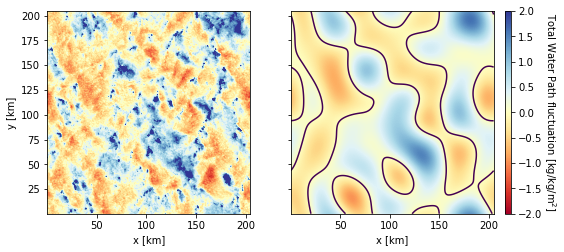

In [11]:
#%% Plot twp, twppf and clouds at a single time step

tPlot = 24

it = np.argmin(abs(tPlot-time))

# Albedo
qli = np.ma.getdata(ds.variables['lwp'][it,:,:])
# tau = 0.19*qli**(5./6)*7e7**(1/3)
# alb = tau/(6.8+tau)
alb = qli.copy()
alb[qli<qlc] = 0
alb[qli>=qlc] = 1

# TWP fluctuation
twpp = np.ma.getdata(ds.variables['twp'][it,:,:])
twpp -= np.median(twpp)

# Low-pass filtered TWP fluctuation
twppf = lowPass(twpp, circ_mask)

fig,axs = plt.subplots(ncols=2,figsize=(8,4),sharey=True)
sc = axs[0].imshow(twpp,extent=extent,vmin=-2,vmax=2,cmap='RdYlBu')
axs[0].set_xlabel('x [km]')
axs[0].set_ylabel('y [km]')

axs[1].imshow(twppf,extent=extent,vmin=-2,vmax=2,cmap='RdYlBu')
axs[1].contour(twppf,levels=[0],extent=extent,origin='upper')
axs[1].set_xlabel('x [km]')

# axs[2].contour(twppf,levels=[0],extent=extent,origin='upper',colors='white')
# axs[2].imshow(alb,extent=extent,vmin=0,vmax=1,cmap='gist_gray')
# axs[2].set_xlabel('x [km]')

pos1 = axs[1].get_position()
cbax = fig.add_axes([.92, pos1.ymin, 0.01, pos1.height])
# cbax = fig.add_axes([1, 0.1, 0.02, 0.85])
# cbax = fig.add_axes([-0.06, 0.1, 0.02, 0.85])
cb = fig.colorbar(sc, cax=cbax)
cb.ax.set_ylabel(r"Total Water Path fluctuation [kg/kg/m$^2$]", rotation=270, labelpad=15) #-65
# plt.tight_layout()
plt.savefig(sp+'/twpfluct.pdf',bbox_inches='tight',dpi=300)

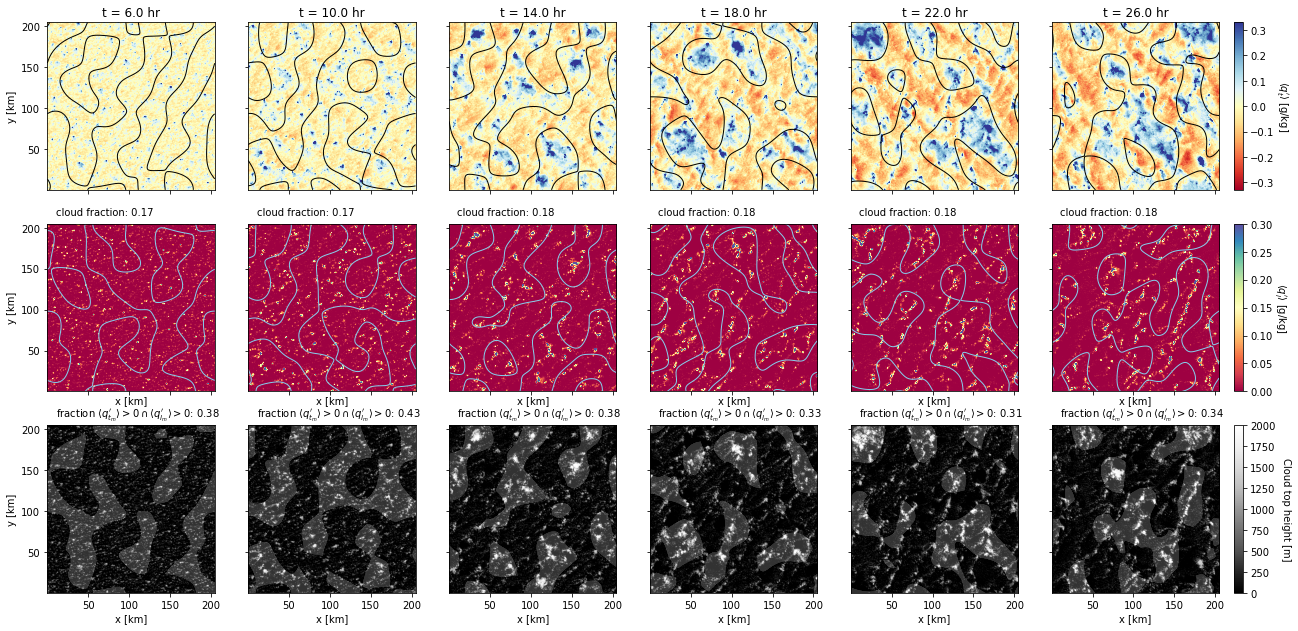

In [12]:
#%% Plot the time evolution of twpp
fq=1e3
tPlot = np.arange(6,28,4)

fig,axs = plt.subplots(ncols=len(tPlot),nrows=3,figsize=(3.5*len(tPlot),3.5*3),
                       sharex=True,sharey=True,squeeze=False)

for j in range(len(tPlot)):
    it = np.argmin(abs(tPlot[j]-time))
    twpp = np.ma.getdata(ds.variables['twp'][it,:,:])
    twpp -= np.mean(twpp)
    twppf = lowPass(twpp, circ_mask)
    
    cm = np.ma.getdata(ds.variables['cldtop'][it,:,:])
    # cm = np.zeros(qli.shape)
    # cm[qli<qlc] = 0
    # cm[qli>=qlc] = 1
    lwp = np.ma.getdata(ds.variables['lwp'][it,:,:])
    lwpp = lwp - np.mean(lwp)
    lwppf = lowPass(lwpp, circ_mask)
    
    cf = np.count_nonzero(cm) / cm.size
    
    mask_moist = np.zeros(twpp.shape)
    mask_moist[twppf>0] = 1
    
    mask_lwppf = np.zeros(lwppf.shape)
    mask_lwppf[lwppf>0] = 1
    
    mask_moist_lwppf = mask_moist*mask_lwppf
    cmqlpf = np.count_nonzero(mask_moist_lwppf) / cm.size
    
#     buoycb = np.ma.getdata(ds.variables['buoycb'][it,:,:])
#     rwp = np.ma.getdata(ds.variables['rwp'][it,:,:])

#     it3 = np.argmin(abs(tPlot[j]-time3))
#     thlp = np.ma.getdata(ds3.variables['thl'][it3,0,:,:])
#     thlp = thlp - np.mean(thlp)

    sc1 = axs[0,j].imshow(twpp*fq/rho0, extent=extent,vmin=-2*fq/rho0,vmax=2*fq/rho0,cmap='RdYlBu')
    
    sc2 = axs[1,j].imshow(lwp , extent=extent,vmin=0,vmax=0.3,cmap='Spectral')
    
    sc3 = axs[2,j].imshow(cm  , extent=extent,vmin=0,vmax=2000,cmap='Greys_r')
    
    if j > -1:
        axs[0,j].contour(twppf*fq/rho0,levels=[0],extent=extent,origin='upper',
                         linewidths=1,colors='black')
#         axs[1,j].contour(twppf*fq/rho0,levels=[0],extent=extent,origin='upper',
#                          linewidths=1,colors='white')
        axs[1,j].contour(lwppf*fq/rho0,levels=[0],extent=extent,origin='upper',
                         linewidths=1,colors='skyblue')
    
#         axs[2,j].contour(twppf*fq/rho0,levels=[0],extent=extent,origin='upper',
#                          linewidths=1,colors='black')
        axs[2,j].imshow(mask_moist_lwppf, extent=extent,vmin=0.5,vmax=1,cmap='Greys_r', alpha=0.2)
#         axs[2,j].imshow(mask_lwppf, extent=extent,vmin=0.5,vmax=1,cmap='Blues', alpha=0.3)        

    axs[1,j].set_xlabel('x [km]')
    axs[2,j].set_xlabel('x [km]')
    axs[0,j].set_title('t = %.1f hr'%tPlot[j])
    if j == 0:
        axs[0,j].set_ylabel('y [km]')
        axs[1,j].set_ylabel('y [km]')
        axs[2,j].set_ylabel('y [km]')
        
    if j == len(tPlot)-1:
        pos1 = axs[0,j].get_position()
        cbax1 = fig.add_axes([.91, pos1.ymin, 0.006, pos1.height])
        cb1 = fig.colorbar(sc1, cax=cbax1)
        cb1.ax.set_ylabel(r"$\langle q_t'\rangle$ [g/kg]", rotation=270, labelpad=15)
        
        pos2 = axs[1,j].get_position()
        cbax2 = fig.add_axes([.91, pos2.ymin, 0.006, pos2.height])
        cb2 = fig.colorbar(sc2, cax=cbax2)
        cb2.ax.set_ylabel(r"$\langle q_l'\rangle$ [g/kg]", rotation=270, labelpad=15)

        pos3 = axs[2,j].get_position()
        cbax3 = fig.add_axes([.91, pos3.ymin, 0.006, pos3.height])
        cb3 = fig.colorbar(sc3, cax=cbax3)
        cb3.ax.set_ylabel(r"Cloud top height [m]", rotation=270, labelpad=15)
    axs[1,j].annotate('cloud fraction: %.2f'%cf, (0.05,1.05),xycoords='axes fraction')
    axs[2,j].annotate(r"fraction $\langle q_{t_m}'\rangle>0 \cap \langle q_{l_m}'\rangle>0$: %.2f"%cmqlpf, (0.05,1.05),xycoords='axes fraction')
plt.savefig(sp+'/twp_cld_overlap.pdf', bbox_inches='tight',dpi=300)


/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
No handles with labels found to put in legend.


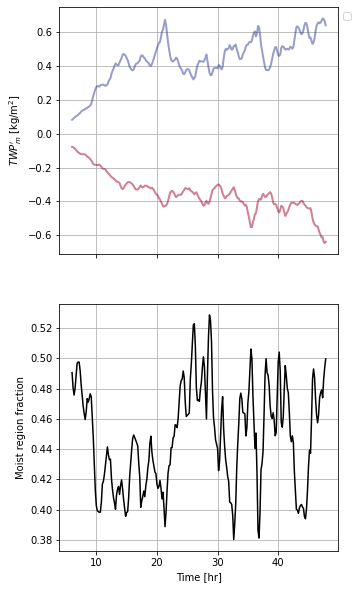

In [14]:
#%% Plot time evolution of twp, for a number of simulations

alpha=0.5
lw=2
col_moist = plt.cm.RdYlBu(0.99)
col_dry = plt.cm.RdYlBu(0)

tmin = 6.
tmax = 48.

itpltmin = np.where(time>=tmin)[0][0]
itpltmax = np.where(time<tmax)[0][-1]+1
plttime_var = np.arange(itpltmin,itpltmax,1)

fig, axs = plt.subplots(nrows=2,figsize=(5,10),sharex=True)

twppf_moist = np.zeros(len(plttime_var))
twppf_dry = np.zeros(len(plttime_var))
frac_moist = np.zeros(len(plttime_var))
for j in range(len(plttime_var)):
    twpp = np.ma.getdata(ds.variables['twp'][plttime_var[j],:,:])
    twpp -= np.mean(twpp)
    twppf = lowPass(twpp, circ_mask)
    mask_moist = np.zeros(twppf.shape)
    mask_moist[twppf > 0] = 1
    mask_dry = 1 - mask_moist
    frac_moist[j] = np.sum(mask_moist) / np.size(mask_moist)

    twppf_moist[j] = mean_mask(twppf, mask_moist)
    twppf_dry[j] = mean_mask(twppf, mask_dry)

axs[0].plot(time[plttime_var],twppf_moist,c=col_moist,lw=lw,alpha=alpha)
axs[0].plot(time[plttime_var],twppf_dry,c=col_dry,lw=lw,alpha=alpha)
axs[1].set_xlabel('Time [hr]')
axs[0].set_ylabel(r"$TWP_m'$ [kg/m$^2$]")
axs[0].legend(loc='upper left',bbox_to_anchor=(1,1))
axs[0].grid()

axs[1].plot(time[plttime_var], frac_moist, c='k')
axs[1].set_ylabel('Moist region fraction')
axs[1].grid()
plt.savefig(sp+'/twp_evo.pdf',bbox_inches='tight')

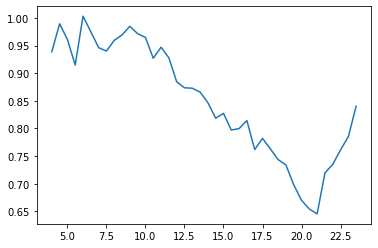

In [7]:
fq=1e3
tPlot = np.arange(4,24,0.5)

cmqlpf = np.zeros(len(tPlot))
cmqlpf75 = np.zeros(len(tPlot))
for j in range(len(tPlot)):
    it = np.argmin(abs(tPlot[j]-time))
    twpp = np.ma.getdata(ds.variables['twp'][it,:,:])
    twpp -= np.median(twpp)
    twppf = lowPass(twpp, circ_mask)
    
    lwp = np.ma.getdata(ds.variables['lwp'][it,:,:])
    lwpp = lwp - np.mean(lwp)
    lwppf = lowPass(lwpp, circ_mask)
    
    cf = np.count_nonzero(cm) / cm.size
    
    mask_moist = np.zeros(twpp.shape)
    mask_moist[twppf>0] = 1
    
    mask_75 = np.zeros(twpp.shape)
    mask_75[twppf>np.percentile(twppf,90)] = 1
    
    mask_lwppf = np.zeros(lwppf.shape)
    mask_lwppf[lwppf>0] = 1

    mask_lwp75 = np.zeros(lwppf.shape)
    mask_lwp75[lwppf>np.percentile(lwppf,90)] = 1

    
    mask_moist_lwppf = np.zeros(cm.shape)
    mask_moist_lwppf[(mask_moist>0.5) & (mask_lwppf>0.5)] = 1 # Moist areas mapping onto qlppf>0 areas
#     mask_moist_lwppf[(mask_moist<0.5) & (mask_lwppf<0.5)] = 1 # Dry areas mapping onto qlppf<0 areas
    cmqlpf[j] = np.count_nonzero(mask_moist_lwppf) / cm.size
    
    mask_75_lwppf = np.zeros(cm.shape)
    mask_75_lwppf[(mask_75>0.5) & (mask_lwp75>0.5)] = 1 # Moist areas mapping onto qlppf>0 areas
    cmqlpf75[j] = np.count_nonzero(mask_75_lwppf) / cm.size

plt.plot(tPlot,cmqlpf/0.5)
# plt.plot(tPlot,cmqlpf75/0.1)

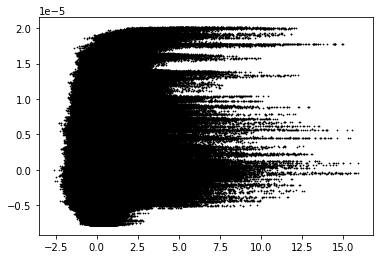

In [21]:
# How does surface precipitation scale as a function of twp?
fq=1e3
tPlot = np.arange(20,24)

for j in range(len(tPlot)):
    it = np.argmin(abs(tPlot[j]-time))
    twpp = np.ma.getdata(ds.variables['twp'][it,:,:])
    twpp -= np.mean(twpp)
    twppf = lowPass(twpp, circ_mask)
    
#     cm = np.ma.getdata(ds.variables['cldtop'][it,:,:])
    # cm = np.zeros(qli.shape)
    # cm[qli<qlc] = 0
    # cm[qli>=qlc] = 1
    surfprec = np.ma.getdata(ds.variables['surfprec'][it,:,:])
    surfprecpp = surfprec - np.mean(surfprec)
    surfprecppf = lowPass(surfprecpp, circ_mask)


    plt.scatter(twpp.flatten(),surfprecppf.flatten(),c='k',s=0.5)
plt.show()